In [1]:
import copy
from collections.abc import Iterable
import functools
import itertools
import operator
from matplotlib import pyplot as plt

import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import numpy_ext as npe
import math
import random
from pprint import pprint
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.sparse import hstack, vstack, csr_matrix
import scipy

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import Normalizer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import joblib

import seaborn as sns

import sys

from config import demographics, vital_sign_vars, lab_vars, treatment_vars, vent_vars, guideline_vars, ffill_windows_clinical, SAMPLE_TIME_H
from config import fio2_bins, peep_bins, tv_bins
import safety

In [220]:
scalers_dir = 'scalers/'
data_dir = 'data/'
seed = 0

SHAPING = False
SHAPING = 'avgpotential'
COMPLIANCE_SCALAR = 0.1 # should be in [0, 5]
GAMMA = 0.99
if not SHAPING:
    shaping_name = 'unshaped'
else:
    shaping_name = SHAPING + '-' + str(COMPLIANCE_SCALAR )
np.random.seed(seed)
random.seed(seed)
all_var_types = [
    vital_sign_vars,
    lab_vars,
    treatment_vars,
    vent_vars,
    guideline_vars,
]
all_vars = functools.reduce(operator.add, all_var_types)

In [3]:
train_set = pd.read_csv(data_dir + 'train_imputed_{}.csv'.format(seed))
clinical_train_scaler = joblib.load(scalers_dir + 'train/clinical_std_scaler_{}.bin'.format(seed))
demographics_train_scaler = joblib.load(scalers_dir + 'train/demographics_std_scaler_{}.bin'.format(seed))

test_set = pd.read_csv(data_dir + 'test_ffilled_{}.csv'.format(seed))
val_set = pd.read_csv(data_dir + 'validation_ffilled_{}.csv'.format(seed))

knn_imputer = joblib.load(scalers_dir + 'train/knn_imputer_{}.bin'.format(seed))
scalers = {}
for var in all_vars + demographics:
    try:
        scalers[var] = joblib.load(scalers_dir + 'train/{}_std_scaler_{}.bin'.format(var, seed))
    except FileNotFoundError:
        pass

# TODO: FIX for test and validation sets: scaling (w/ train scaler?), knn imputation (w/ train clusterer), scaling (w/ train scaler?) and clustering (w/ train clusterer)
# for df in (test_set, val_set):
#     vars_to_impute = []
#     for var in all_vars:
#         if pd.api.types.is_numeric_dtype(df[var]):
#             ffilled = var + '_imp'
#             non_nas = df[~df[ffilled].isna()][ffilled].to_numpy().reshape(-1,1)
#             scaled = scalers[var].transform(non_nas)
#             scaledvarname = ffilled + '_scaled'
#             df[scaledvarname] = pd.Series(scaled.reshape(1,-1)[0])
#             vars_to_impute.append(scaledvarname)
#     for var in demographics:
#         if pd.api.types.is_numeric_dtype(df[var]):
#             non_nas = df[~df[var].isna()][var].to_numpy().reshape(-1, 1)
#             scaled = scalers[var].transform(df[var].to_numpy().reshape(-1,1))
#             scaledvarname = var + '_scaled'
#             df[scaledvarname] = pd.Series(scaled.reshape(1,-1)[0])
#             vars_to_impute.append(scaledvarname)
#     knn_imputed_vars = list(map(lambda x: x + '_impknn', vars_to_impute))
#     imputed = knn_imputer.transform(df[vars_to_impute].to_numpy())
#     df.loc[:, knn_imputed_vars] = imputed

/home/floris/anaconda3/envs/ventrl/lib/python3.11/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/floris/anaconda3/envs/ventrl/lib/python3.11/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator KNNImputer from version 1.1.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
# NOTE: these have not been rescaled after imputation
test_set.to_csv(data_dir + 'test_imputed_{}.csv'.format(seed))
val_set.to_csv(data_dir + 'validation_imputed_{}.csv'.format(seed))

In [5]:
var_to_state_var = {}
for var in all_vars + demographics:
    if var + '_imp_scaled_impknn' in train_set.columns:
        var_to_state_var[var] = var + '_imp_scaled_impknn'
    elif var + '_scaled_impknn' in train_set.columns:
        var_to_state_var[var] = var + '_scaled_impknn'
        
# TODO: validate if this contains all vars
state_variables = list(var_to_state_var.values())

In [6]:
longest_sv = max(map(len, state_variables))
for sv in state_variables:
    print(("{:<" + str(longest_sv) +"}: {:.4f} {:.4f} {:.4f}").format(sv, train_set[sv].mean(), train_set[sv].median(), train_set[sv].var()))

sofa_imp_scaled_impknn              : -0.0026 0.2198 1.0438
sirs_imp_scaled_impknn              : 0.0089 -0.1169 1.0001
gcs_imp_scaled_impknn               : 0.0577 0.1187 1.0482
heartrate_imp_scaled_impknn         : 0.0049 -0.0585 0.9951
sysbp_imp_scaled_impknn             : -0.0253 -0.1561 0.9926
meanbp_imp_scaled_impknn            : -0.0170 -0.1304 0.9938
diasbp_imp_scaled_impknn            : -0.0101 -0.0920 1.0069
shockindex_imp_scaled_impknn        : 0.0141 -0.1115 1.0264
resprate_imp_scaled_impknn          : 0.0358 -0.0699 1.0047
spo2_imp_scaled_impknn              : -0.0665 0.0728 1.0438
tempc_imp_scaled_impknn             : -0.0362 -0.0307 0.9891
potassium_imp_scaled_impknn         : 0.0372 -0.0733 0.9617
sodium_imp_scaled_impknn            : -0.0334 -0.0790 0.9801
chloride_imp_scaled_impknn          : -0.0357 0.0087 1.0001
glucose_imp_scaled_impknn           : 0.0108 -0.1800 1.0191
bun_imp_scaled_impknn               : 0.0773 -0.2326 1.0690
creatinine_imp_scaled_impknn        

In [7]:
# NOTE: mirror the changes made here in the 'unscale' logic
rescaler = StandardScaler()

rescaled = rescaler.fit_transform(train_set[state_variables])
rs_state_varnames = [var + '_rescaled' for var in state_variables]
train_set[rs_state_varnames] = rescaled

rescaled_test = rescaler.transform(test_set[state_variables])
test_set[rs_state_varnames] = rescaled_test

In [8]:
n_states = 650 # according to Peine's paper
clusterer = KMeans(n_clusters=n_states)
train_clusters = clusterer.fit_predict(train_set[rs_state_varnames])
test_clusters = clusterer.predict(test_set[rs_state_varnames])

/home/floris/anaconda3/envs/ventrl/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'Train set state cluster distr')

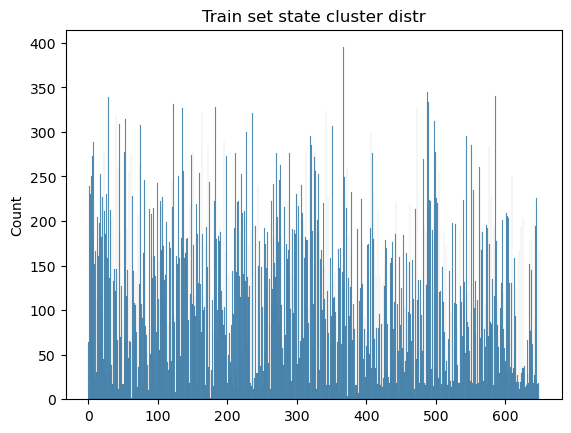

In [9]:
sns.histplot(train_clusters, bins=n_states)
plt.title('Train set state cluster distr')

Text(0.5, 1.0, 'Test set state cluster distr')

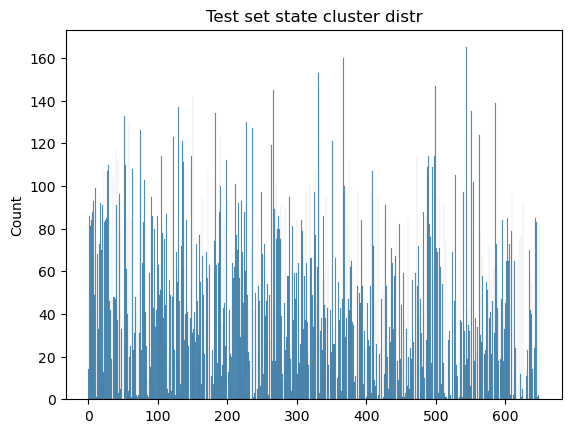

In [10]:
sns.histplot(test_clusters, bins=n_states)
plt.title('Test set state cluster distr')

In [11]:
clusters = pd.Series(train_clusters)
test_clusters_series = pd.Series(test_clusters)
clusters.value_counts()

367    395
488    345
586    340
28     339
490    334
      ... 
447      6
373      4
469      4
175      1
62       1
Length: 650, dtype: int64

In [12]:
longest_sv = max(map(len, rs_state_varnames))
for sv in rs_state_varnames:
    print(("{:<" + str(longest_sv) +"}: {:.4f} {:.4f} {:.4f}").format(sv, train_set[sv].mean(), train_set[sv].median(), train_set[sv].var()))

sofa_imp_scaled_impknn_rescaled              : 0.0000 0.2176 1.0000
sirs_imp_scaled_impknn_rescaled              : -0.0000 -0.1258 1.0000
gcs_imp_scaled_impknn_rescaled               : 0.0000 0.0595 1.0000
heartrate_imp_scaled_impknn_rescaled         : -0.0000 -0.0636 1.0000
sysbp_imp_scaled_impknn_rescaled             : 0.0000 -0.1312 1.0000
meanbp_imp_scaled_impknn_rescaled            : 0.0000 -0.1138 1.0000
diasbp_imp_scaled_impknn_rescaled            : -0.0000 -0.0817 1.0000
shockindex_imp_scaled_impknn_rescaled        : 0.0000 -0.1240 1.0000
resprate_imp_scaled_impknn_rescaled          : -0.0000 -0.1055 1.0000
spo2_imp_scaled_impknn_rescaled              : 0.0000 0.1364 1.0000
tempc_imp_scaled_impknn_rescaled             : 0.0000 0.0055 1.0000
potassium_imp_scaled_impknn_rescaled         : -0.0000 -0.1127 1.0000
sodium_imp_scaled_impknn_rescaled            : -0.0000 -0.0460 1.0000
chloride_imp_scaled_impknn_rescaled          : -0.0000 0.0444 1.0000
glucose_imp_scaled_impknn_rescal

In [13]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train_set[rs_state_varnames])

Text(0.5, 1.0, 'Clustering Result Train (k=650, rescaled, PCA)')

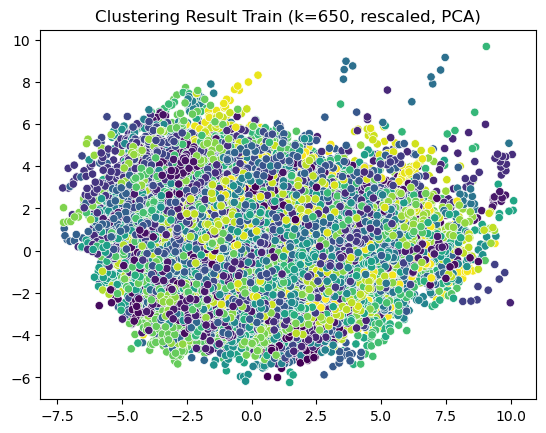

In [14]:
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], c=train_clusters)
plt.title('Clustering Result Train (k={}, rescaled, PCA)'.format(n_states))

Text(0.5, 1.0, 'Clustering Result Test (k=650, rescaled, PCA)')

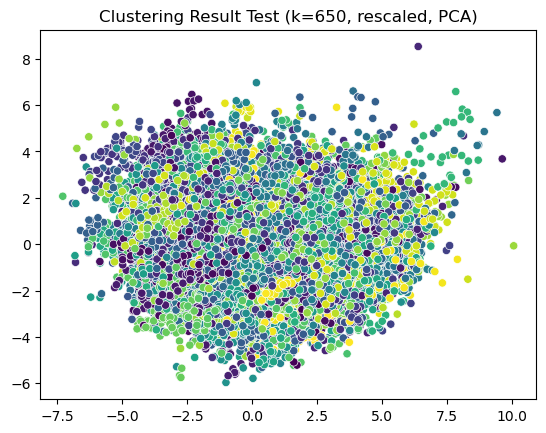

In [15]:
#pca = PCA(n_components=2)
#pca_result = pca.fit_transform(test_set[rs_state_varnames])
pca_result = pca.transform(test_set[rs_state_varnames])
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], c=test_clusters)
plt.title('Clustering Result Test (k={}, rescaled, PCA)'.format(n_states))

In [16]:
print("""silhouette: {}, [-1, 1], higher is better
calinksi-harabasz: {}, higher is better
davies-bouldin: {}, [0, ∞], lower is better""".format(
    metrics.silhouette_score(train_set[rs_state_varnames], train_clusters),
    metrics.calinski_harabasz_score(train_set[rs_state_varnames], train_clusters),
    metrics.davies_bouldin_score(train_set[rs_state_varnames], train_clusters)))

silhouette: 0.05454804130660323, [-1, 1], higher is better
calinksi-harabasz: 151.7882105319104, higher is better
davies-bouldin: 2.325112714955797, [0, ∞], lower is better


In [17]:
train_set['state'] = clusters
test_set['state'] = test_clusters_series

# Unscale - back to original and interpretable space

In [18]:
# This step is spurious for now, as there is no imputation after rescaling
un_rescaled_state_vars = rescaler.inverse_transform(train_set[rs_state_varnames])
un_rescaled_state_vars_test = rescaler.inverse_transform(test_set[rs_state_varnames])

clinical_scaled_varnames = [var + '_impknn' for var in joblib.load('scalers/train/clinical_std_varnames_{}.bin'.format(seed))]
demographics_scaled_varnames = [var + '_impknn' for var in joblib.load('scalers/train/demographics_std_varnames_{}.bin'.format(seed))]
unscaled_clinical_vars = clinical_train_scaler.inverse_transform(train_set[clinical_scaled_varnames])
unscaled_clinical_vars_test = clinical_train_scaler.inverse_transform(test_set[clinical_scaled_varnames])
unscaled_demo_vars = demographics_train_scaler.inverse_transform(train_set[demographics_scaled_varnames])
unscaled_demo_vars_test = demographics_train_scaler.inverse_transform(test_set[demographics_scaled_varnames])


unscaled_clinical_varnames = [var + '_unscaled' for var in clinical_scaled_varnames]
unscaled_demographics_varnames = [var + '_unscaled' for var in demographics_scaled_varnames]
train_set[unscaled_clinical_varnames] = unscaled_clinical_vars
test_set[unscaled_clinical_varnames] = unscaled_clinical_vars_test
train_set[unscaled_demographics_varnames] = unscaled_demo_vars
test_set[unscaled_demographics_varnames] = unscaled_demo_vars_test

In [19]:
# validation unscaling
#  * does not introduce NaNs
#  * does not change known values (by some error margin)
clinical_varname_pairs = list(zip(unscaled_clinical_varnames, map(lambda x: x.replace("_imp_scaled_impknn", ""), clinical_scaled_varnames)))
demo_varname_pairs = list(zip(unscaled_demographics_varnames, map(lambda x: x.replace("_scaled_impknn", ""), demographics_scaled_varnames)))
all_varname_pairs = clinical_varname_pairs + demo_varname_pairs
for (unscaled, original) in all_varname_pairs:
    print(unscaled, original)
    # check that the number of NaNs for unscaled is less or equal than original
    assert train_set[unscaled].isna().sum() <= train_set[original].isna().sum(), "Unscaling has introduced NaNs in train set"
    assert test_set[unscaled].isna().sum() <= test_set[original].isna().sum(), "Unscaling has introduced NaNs in test set"
    # calculate difference between unscaled and original value
    difference = np.absolute(train_set[~train_set[unscaled].isna()][unscaled] - train_set[~train_set[unscaled].isna()][original])
    difference_test = np.absolute(test_set[~test_set[unscaled].isna()][unscaled] - test_set[~test_set[unscaled].isna()][original])
    # difference should be small OR the original should be NaN.
    assert ((difference < 0.0001) | train_set[~train_set[unscaled].isna()][original].isna()).all(), "Unscaling introduced errors for variable '{}' in train set".format(original)
    assert ((difference_test < 0.0001) | test_set[~test_set[unscaled].isna()][original].isna()).all(), "Unscaling introduced errors for variable '{}' in test set".format(original)

sofa_imp_scaled_impknn_unscaled sofa
sirs_imp_scaled_impknn_unscaled sirs
gcs_imp_scaled_impknn_unscaled gcs
heartrate_imp_scaled_impknn_unscaled heartrate
sysbp_imp_scaled_impknn_unscaled sysbp
meanbp_imp_scaled_impknn_unscaled meanbp
diasbp_imp_scaled_impknn_unscaled diasbp
shockindex_imp_scaled_impknn_unscaled shockindex
resprate_imp_scaled_impknn_unscaled resprate
spo2_imp_scaled_impknn_unscaled spo2
tempc_imp_scaled_impknn_unscaled tempc
potassium_imp_scaled_impknn_unscaled potassium
sodium_imp_scaled_impknn_unscaled sodium
chloride_imp_scaled_impknn_unscaled chloride
glucose_imp_scaled_impknn_unscaled glucose
bun_imp_scaled_impknn_unscaled bun
creatinine_imp_scaled_impknn_unscaled creatinine
magnesium_imp_scaled_impknn_unscaled magnesium
calcium_imp_scaled_impknn_unscaled calcium
ionizedcalcium_imp_scaled_impknn_unscaled ionizedcalcium
carbondioxide_imp_scaled_impknn_unscaled carbondioxide
bilirubin_imp_scaled_impknn_unscaled bilirubin
albumin_imp_scaled_impknn_unscaled albumin
h

## Compute derived values
- normalized tidal volume: tv in ml/Kg of adult ideal body weight

In [20]:
# derived variables based on imputed / normalized values
# - tidal_volume
train_set['tv_derived'] = train_set['tidal_volume_imp_scaled_impknn_unscaled'] / train_set['adult_ibw_scaled_impknn_unscaled']
test_set['tv_derived'] = test_set['tidal_volume_imp_scaled_impknn_unscaled'] / test_set['adult_ibw_scaled_impknn_unscaled']

In [21]:
(train_set.adult_ibw_scaled_impknn_unscaled < 0).sum()

0

# Action space discretization
The action space consists of three dimensions:
* Tidal volume (ml/Kg), where Kg refers to the ideal body weight
* PEEP (cmH20) positive end-expiration pressure
* FiO2 (%) fraction of inspired oxygen

These three dimensions are each discretized into 7 bins, rendering a total of 7^3 = 343 actions.  
The action bins are defined per dimension and according to Peine in ``config.py``.
Here we map all possible actions to a discrete identifier action.

In [22]:
# a definition of all actions
action_bin_definition = list(itertools.product(tv_bins, fio2_bins, peep_bins))
# the lower bounds for the three variables in the action space
lower_bounds = [[var[0] for var in ranges] for ranges in action_bin_definition] 

In [23]:
assert to_discrete_action(1, 25, 0) == 0, "the first action does not have id 0"             # the first action
assert to_discrete_action(1, 25, 5) == 1, "the second action does not have id 1"             # the second action
assert to_discrete_action(1, 25, sys.maxsize) == 6, "the last action in the third dimension does not have id 6"   # very high value for 3rd dimension (peep)
assert to_discrete_action(2.5, 25, 0) == 7*7, "the last action in the second dimension does not have id 7*7"         # second bin for the first dimension (tv)
assert to_discrete_action(sys.maxsize,
                          sys.maxsize,
                          sys.maxsize) == 7**3 - 1, "an action with very high values does not have id 7**3 -1"   # very high value for all bins

In [24]:
tv_clinical = 'tv_derived'
peep_clinical = 'peep_imp_scaled_impknn_unscaled'
fio2_clinical = 'fio2_imp_scaled_impknn_unscaled'

discretized_actions = train_set.apply(lambda x: to_discrete_action(x[tv_clinical], x[fio2_clinical], x[peep_clinical]), axis=1)
discretized_actions_test = test_set.apply(lambda x: to_discrete_action(x[tv_clinical], x[fio2_clinical], x[peep_clinical]), axis=1)

train_set['action_discrete'] = discretized_actions
test_set['action_discrete'] = discretized_actions_test

In [25]:
# sanity spot check -- do the sample values fall in the ranges?
train_set[[tv_clinical, peep_clinical, fio2_clinical]].iloc[0], discretized_actions[0], action_bin_definition[discretized_actions[0]]

(tv_derived                          8.318516
 peep_imp_scaled_impknn_unscaled     7.400000
 fio2_imp_scaled_impknn_unscaled    68.000000
 Name: 0, dtype: float64,
 191,
 ((7.5, 10), (55, inf), (7, 9)))

# Analysis of action and state-action distributions

In [26]:
observed_action_counts = discretized_actions.value_counts()
action_info = {}
action_counts = []
for action_id in range(len(action_bin_definition)):
    count = observed_action_counts[action_id] if action_id in observed_action_counts else 0
    action_info[action_id] = (action_bin_definition, count)
    action_counts.append(count)
action_counts = pd.Series(action_counts)

# possible actions: 343
actions never chosen: 124
most chosen action: (tv: (7.5, 10), peep:(40, 45), fio2: (5, 7)), chosen 12766 times


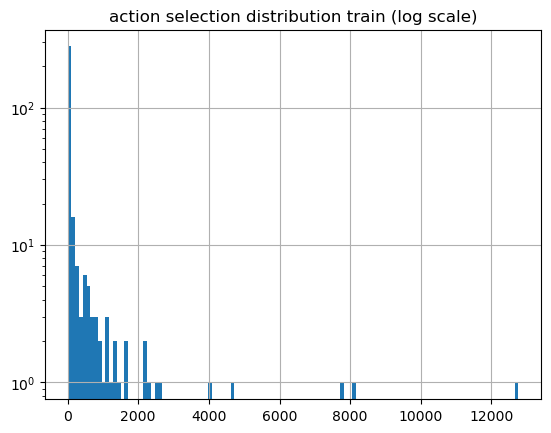

In [27]:
action_counts.hist(bins=action_counts.nunique(), log=True)
plt.title('action selection distribution train (log scale)')
print("# possible actions: {}".format(len(action_bin_definition)))
print("actions never chosen: {}".format((action_counts == 0).sum()))
most_chosen_action = action_bin_definition[discretized_actions.mode()[0]]
print("most chosen action: (tv: {}, peep:{}, fio2: {}), chosen {} times".format(*most_chosen_action, discretized_actions.value_counts().max()))

# possible actions: 343
actions never chosen: 168
most chosen action: (tv: (7.5, 10), peep:(40, 45), fio2: (5, 7)), chosen 4526 times


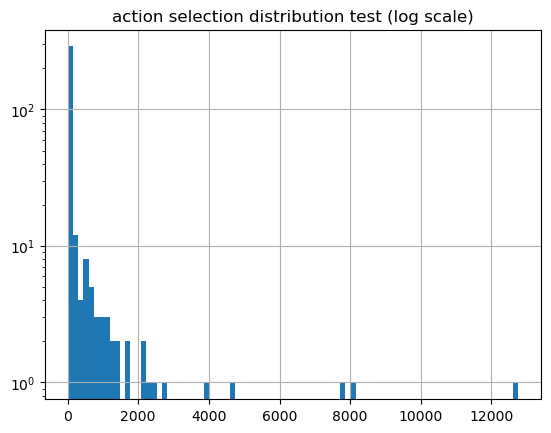

In [28]:
observed_action_counts_test = discretized_actions_test.value_counts()
action_info_test = {}
action_counts_test = []
for action_id in range(len(action_bin_definition)):
    count = observed_action_counts_test[action_id] if action_id in observed_action_counts_test else 0
    action_info_test[action_id] = (action_bin_definition, count)
    action_counts_test.append(count)
action_counts_test = pd.Series(action_counts_test)
action_counts.hist(bins=action_counts_test.nunique(), log=True)
plt.title('action selection distribution test (log scale)')
print("# possible actions: {}".format(len(action_bin_definition)))
print("actions never chosen: {}".format((action_counts_test == 0).sum()))
most_chosen_action = action_bin_definition[discretized_actions_test.mode()[0]]
print("most chosen action: (tv: {}, peep:{}, fio2: {}), chosen {} times".format(*most_chosen_action, discretized_actions_test.value_counts().max()))

In [29]:
# state-action pair
state_actions = list(itertools.product(range(n_states), range(len(action_bin_definition)),))
print("{} states x {} actions = {} state-action pairs".format(n_states, len(action_bin_definition), len(state_actions)))
state_action_ids = list(map(lambda x: "{}-{}".format(x[0], x[1]), state_actions))

650 states x 343 actions = 222950 state-action pairs


In [30]:
train_set['terminal'] = False
train_set.loc[train_set.groupby('icustay_id').tail(1).index, 'terminal'] = True

train_set['state_action_id'] = train_set.agg('{0[state]}-{0[action_discrete]}'.format, axis=1)
train_set['next_state'] = train_set.state.astype(str).shift(-1)
# create special terminal states for both outcomes
terminal_mort = train_set['state'].max() + 1
terminal_nonmort = train_set['state'].max() + 2
        
train_set.loc[train_set.terminal & (train_set.mort90day == 't'), 'next_state'] = terminal_mort
train_set.loc[train_set.terminal & (train_set.mort90day == 'f'), 'next_state'] = terminal_nonmort

# State-Action-NextState_ID
train_set['sans_id'] = train_set.agg('{0[state_action_id]}-{0[next_state]}'.format, axis=1)
observed_saction_counts = train_set['state_action_id'].value_counts()
saction_info = {}
saction_counts = []
for i, saction_id in enumerate(state_action_ids):
    count = observed_saction_counts[saction_id] if saction_id in observed_saction_counts else 0
    state, action = saction_id.split('-')
    saction_info[saction_id] = (saction_id, i, count, int(state), int(action), action_bin_definition[int(action)], )
    saction_counts.append(count)
saction_counts = pd.Series(saction_counts)
# saction_info

In [31]:
test_set['state_action_id'] = test_set.agg('{0[state]}-{0[action_discrete]}'.format, axis=1)
test_set['next_state'] = test_set.state.astype(str).shift(-1)
# State-Action-NextState_ID
test_set['sans_id'] = test_set.agg('{0[state_action_id]}-{0[next_state]}'.format, axis=1)
observed_saction_counts_test = test_set['state_action_id'].value_counts()
saction_info_test = {}
saction_counts_test = []
for i, saction_id in enumerate(state_action_ids):
    count = observed_saction_counts_test[saction_id] if saction_id in observed_saction_counts_test else 0
    state, action = saction_id.split('-')
    saction_info_test[saction_id] = (saction_id, i, count, int(state), int(action), action_bin_definition[int(action)], )
    saction_counts_test.append(count)
saction_counts_test = pd.Series(saction_counts_test)
# saction_info_test

In [32]:
saction_info_df = pd.DataFrame([[*v,] for k, v in  saction_info.items()], columns=['saction_id', 'index', 'count', 'state', 'action', 'action'])
saction_info_df_test = pd.DataFrame([[*v,] for k, v in  saction_info_test.items()], columns=['saction_id', 'index', 'count', 'state', 'action', 'action'])

# state-action pairs: 222950
# state-action pairs never visited: 207995
most visited state-action pair in train: (tv: (7.5, 10), peep:(40, 45), fio2: (5, 7), state: 53), visited 149 times


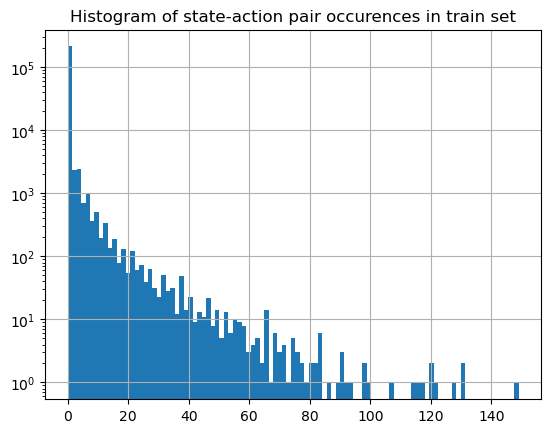

In [34]:
print("# state-action pairs: {}".format(len(state_action_ids)))
print("# state-action pairs never visited: {}".format((saction_counts == 0).sum()))
most_frequent_saction = saction_info_df[saction_info_df.index == saction_counts.argmax()].to_numpy()[0]
most_chosen_action = action_bin_definition[discretized_actions.mode()[0]]
saction_counts.hist(bins=saction_counts.nunique(), log=True)
plt.title("Histogram of state-action pair occurences in train set")
print("most visited state-action pair in train: (tv: {}, peep:{}, fio2: {}, state: {}), visited {} times".format(*most_chosen_action, most_frequent_saction[3], most_frequent_saction[2]))

most visited state-action pair in train: (tv: (7.5, 10), peep:(40, 45), fio2: (5, 7), state: 53), visited 149 times


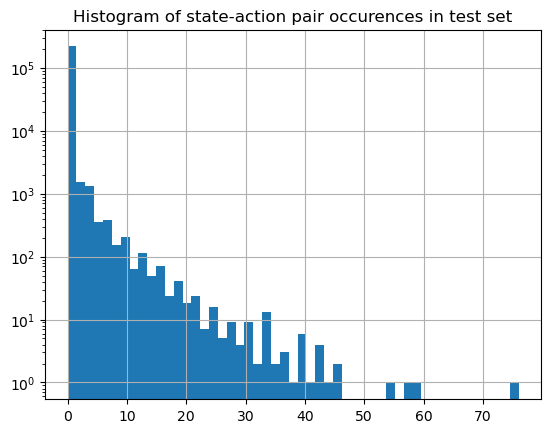

In [35]:
most_frequent_saction_test = saction_info_df[saction_info_df.index == saction_counts.argmax()].to_numpy()[0]
most_chosen_action_test = action_bin_definition[discretized_actions.mode()[0]]
saction_counts_test.hist(bins=saction_counts_test.nunique(), log=True)
plt.title("Histogram of state-action pair occurences in test set")
print("most visited state-action pair in train: (tv: {}, peep:{}, fio2: {}, state: {}), visited {} times".format(*most_chosen_action_test, most_frequent_saction_test[3], most_frequent_saction_test[2]))

## Trajectory construction

count    5239.000000
mean       15.804161
std         3.391786
min         7.000000
25%        13.000000
50%        18.000000
75%        18.000000
max        18.000000
Name: traj_count, dtype: float64

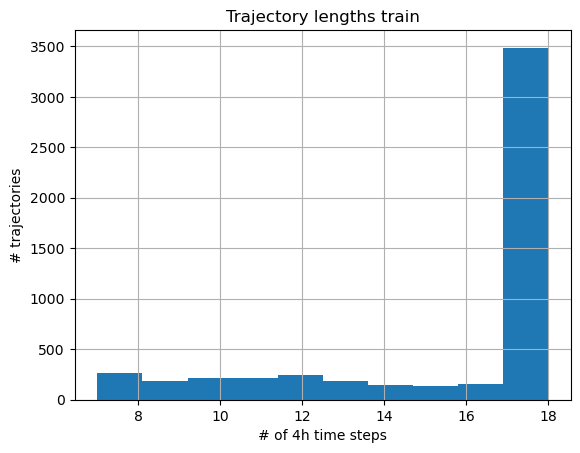

In [36]:
train_set['traj_count'] = train_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount()
train_set['traj_count_inv'] = train_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount(ascending=False)
train_set['traj_len'] = train_set.groupby('icustay_id', as_index=False)['traj_count'].agg({'traj_len': 'max'})['traj_len']
train_set['traj_len'] += 1

trajectory_lengths = train_set.groupby('icustay_id').traj_count.max() + 1
trajectory_lengths.hist()
plt.title('Trajectory lengths train')
plt.xlabel('# of 4h time steps')
plt.ylabel('# trajectories')
trajectory_lengths.describe()

count    1778.000000
mean       15.894826
std         3.335096
min         7.000000
25%        14.000000
50%        18.000000
75%        18.000000
max        18.000000
Name: traj_count, dtype: float64

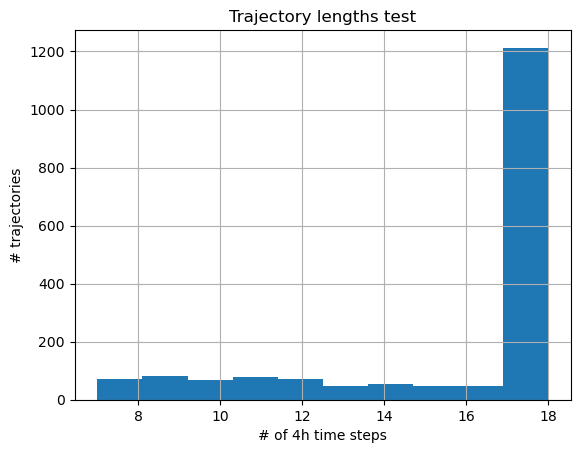

In [37]:
test_set['traj_count'] = test_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount()
test_set['traj_count_inv'] = test_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount(ascending=False)
test_set['traj_len'] = test_set.groupby('icustay_id', as_index=False)['traj_count'].agg({'traj_len': 'max'})['traj_len']
test_set['traj_len'] += 1

trajectory_lengths_test = test_set.groupby('icustay_id').traj_count.max() + 1
trajectory_lengths_test.hist()
plt.title('Trajectory lengths test')
plt.xlabel('# of 4h time steps')
plt.ylabel('# trajectories')
trajectory_lengths_test.describe()

In [38]:
terminals = train_set.groupby('icustay_id').max('traj_count').reset_index().set_index('Unnamed: 0')['traj_count']
terminals = (~terminals.isna()).rename('terminal')
if 'terminal' in train_set.columns:
    # need to remove this column if it already exists
    del(train_set['terminal'])
train_set = train_set.join(terminals, on='Unnamed: 0', how='left')
train_set['terminal'] = train_set.terminal.fillna(False)
train_set['nterminal'] = train_set.terminal.shift(-1).fillna(False)

terminals = test_set.groupby('icustay_id').max('traj_count').reset_index().set_index('Unnamed: 0')['traj_count']
terminals = (~terminals.isna()).rename('terminal')
if 'terminal' in test_set.columns:
    # need to remove this column if it already exists
    del(test_set['terminal'])
test_set = test_set.join(terminals, on='Unnamed: 0', how='left')
test_set['terminal'] = test_set.terminal.fillna(False)
test_set['nterminal'] = test_set.terminal.shift(-1).fillna(False)

In [39]:
assert train_set.groupby('icustay_id').terminal.sum().max() == 1, "Every icustay should have exactly 1 terminal state"
assert test_set.groupby('icustay_id').terminal.sum().max() == 1, "Every icustay should have exactly 1 terminal state"
assert train_set.groupby('icustay_id').terminal.sum().min() == 1, "Every icustay should have exactly 1 terminal state"
assert test_set.groupby('icustay_id').terminal.sum().min() == 1, "Every icustay should have exactly 1 terminal state"

In [42]:
# generate s,s',a tuples for transition matrix approximation
  
# calculate joint state-action probabilities
pr_state_action = pd.DataFrame((train_set.state_action_id.value_counts() / train_set.shape[0])).reset_index().rename(columns={'index': 'sa_id', 'state_action_id': 'pr_sa'})


# calculate joint s-s'-a probabilities
sans_id = '' # state-action-nstate id
pr_nstate_state_action = pd.DataFrame(train_set.sans_id.value_counts() / train_set.shape[0]).reset_index().rename(columns={'index': 'sans_id', 'sans_id': 'pr_sans'})
pr_nstate_state_action['sa_id'] = list(map(lambda x: '-'.join(x[:2]), pr_nstate_state_action.sans_id.str.split('-')))
pr_sans = pr_nstate_state_action.merge(pr_state_action, on='sa_id', how='inner').set_index('sans_id')

# calculate transition probabilities
pr_trans = pr_sans.pr_sans / pr_sans.pr_sa
pr_trans = pd.DataFrame(pr_trans).rename(columns={0: 'pr_t'})



Text(0.5, 1.0, 'Distribution of nonzero transition probabilities')

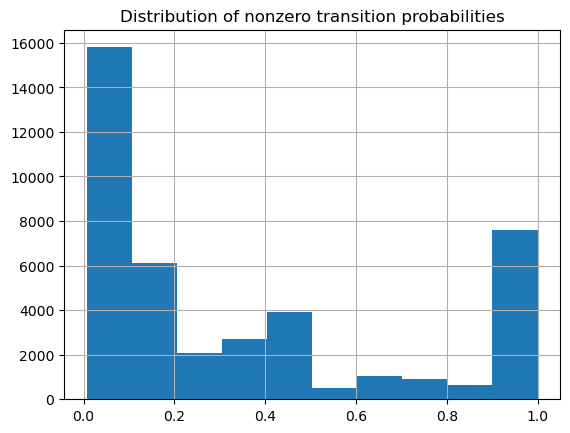

In [43]:
pr_trans.pr_t.hist()
pr_trans
plt.title('Distribution of nonzero transition probabilities')

In [44]:
split_sans = pd.DataFrame(pr_trans.index.str.split('-').tolist()).rename(columns={0:'state', 1: 'action', 2: 'nstate'})
split_sans.state = split_sans.state.astype(int)
split_sans.action = split_sans.action.astype(int)
split_sans.nstate = split_sans.nstate.astype(int)
assert split_sans.action.max() <= (7**3 - 1), "the highest action id exceeds the number of actions" # number of discrete actions
pr_trans = pr_trans.reset_index().merge(split_sans, left_index=True, right_index=True)

In [46]:
# all transition probabilities for a state-action pair should sum to 1, there could be some rounding errors
print("{:.5f}% of state-action's probs does not sum to 1, max diff to 1 is {}".format(
    (~(pr_trans.groupby(['state', 'action']).pr_t.sum() >= 1.0)).to_numpy().mean(),
    np.diff(pr_trans.groupby(['state', 'action']).pr_t.sum(), 1).max(),
))
assert np.diff(pr_trans.groupby(['state', 'action']).pr_t.sum(), 1).max() < 1e-15, "transition probabilities for a state-action pair should sum (approx.) to 1"

0.01143% of state-action's probs does not sum to 1, max diff to 1 is 3.3306690738754696e-16


In [47]:
np.diff(pr_trans.groupby(['state', 'action']).pr_t.sum(), 1).max()

3.3306690738754696e-16

Text(0.5, 1.0, 'Histogram of nonzero transition probabilities')

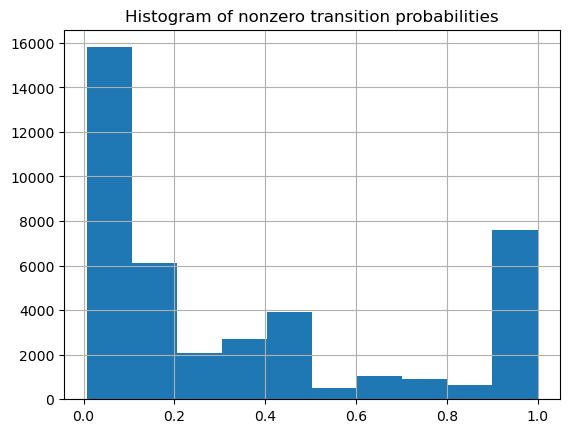

In [48]:
pr_trans.pr_t.hist()
plt.title('Histogram of nonzero transition probabilities')

## Immediate reward definition

In [252]:
def compliance_to_potential(compliance):
    return compliance * COMPLIANCE_SCALAR

def potential_diff(x):
    if np.isnan(x.iloc[1]):
        p1 = 0.0 # see Grzes, AAMAS 2017
    else:
        p1 = GAMMA * x.iloc[1]
    return p1 - x.iloc[0]

train_set['reward'] = 0
test_set['reward'] = 0
train_set.loc[train_set.terminal & (train_set.mort90day == 't'), 'reward'] = -100
test_set.loc[test_set.terminal & (test_set.mort90day == 't'), 'reward'] = -100
train_set.loc[train_set.terminal & (train_set.mort90day == 'f'), 'reward'] = 100
test_set.loc[test_set.terminal & (test_set.mort90day == 'f'), 'reward'] = 100


assert train_set.reward.isna().sum() == 0, "All immediate rewards should be set"
assert test_set.reward.isna().sum() == 0, "All immediate rewards should be set"
assert train_set[train_set.terminal].reward.isin({-100, 100}).all(), "Transitions to terminal states should have value -100 or 100"
assert test_set[test_set.terminal].reward.isin({-100, 100}).all(), "Transitions to terminal states should have value -100 or 100"

if SHAPING:
    # TODO FdH: implement shaping
    if SHAPING == 'avgpotential2':
        train_set['compliance'] = safety.state_compliance_clinical(train_set, safety.avg_clinical_timestep)
    elif SHAPING == 'allpotential':
        train_set['compliance'] = safety.state_compliance_clinical(train_set, safety.all_clinical_timestep)
    else:
        raise ValueError('Unknown shaping approach')
    train_set['potential'] = compliance_to_potential(train_set['compliance'])
    if 'potential' in SHAPING:
        train_set['shaping_reward_unshift'] = train_set.groupby('icustay_id').rolling(window=2)['potential'].apply(potential_diff).fillna(0.0).reset_index().set_index('level_1')['potential']
        train_set['shaping_reward'] = train_set['shaping_reward_unshift'].shift(-1)
        train_set.loc[train_set.terminal, 'shaping_reward'] = train_set['potential']
    elif 'base' in SHAPING:
        train_set['shaping_reward'] = train_set['potential']
    
    train_set['reward'] = train_set.reward + train_set.shaping_reward

 0.000000      29402
 100.000000     2045
 0.020000       1968
-0.020000       1550
-100.000000     1261
               ...  
-0.004286          1
 0.001081          1
 0.000870          1
-0.001538          1
 0.002667          1
Name: reward, Length: 478, dtype: int64

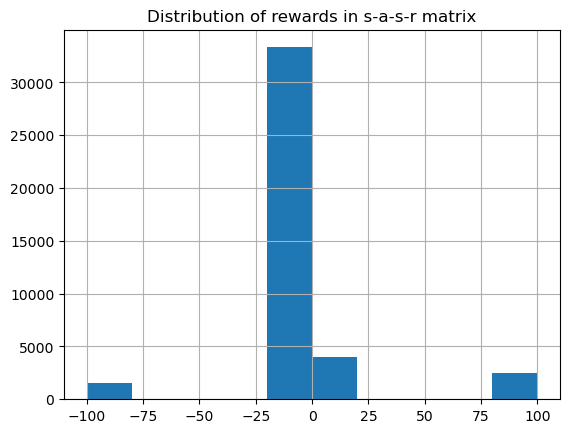

In [173]:
# 1. compute average immediate reward for each s-s'-a with support from the data.
# 2. where -100 if terminal and 90 day mortality, +100 if terminal and 90 day mortality, 0 otherwise
# 3. element-wise multiply with transition matrix pr_trans
# 4. sum over s' dimension to obtain R(s, a) < sum because transition matrix has probabilities

# step 1: compute average immediate reward for each s-s'-a with support from the data.
r_sans = train_set.groupby('sans_id')['reward'].mean()
r_sans.hist()
plt.title('Distribution of rewards in s-a-s-r matrix')
split_r_sans = pd.DataFrame(r_sans.index.str.split('-').tolist()).rename(columns={0:'state', 1: 'action', 2: 'nstate'})
split_r_sans.state = split_r_sans.state.astype(int)
split_r_sans.action = split_r_sans.action.astype(int)
split_r_sans.nstate = split_r_sans.nstate
r_sans = r_sans.reset_index().merge(split_r_sans, left_index=True, right_index=True)
r_sans.reward.value_counts()

In [174]:
pr_r_sans = r_sans.merge(pr_trans, on='sans_id')
assert pr_r_sans.pr_t.isna().sum() == 0, "transition probabilities should never be na"
assert pr_r_sans.reward.isna().sum() == 0, "rewards should never be na"
assert pr_r_sans.shape[0] == r_sans.shape[0], "all reward rows should be in transition-reward dataframe"
assert pr_r_sans.shape[0] == pr_sans.shape[0], "all transition rows should be in transition-reward dataframe"
assert pr_r_sans.sans_id.value_counts().max() == 1, "a s-a-r-s tuple should occur exactly once"
assert pr_r_sans.sans_id.value_counts().min() == 1, "a s-a-r-s tuple should occur exactly once"

In [175]:
# step 3: element-wise multiply with transition matrix pr_trans
pr_r_sans['weighted_reward'] = pr_r_sans.reward * pr_r_sans.pr_t
immediate_reward = pr_r_sans.groupby(['state_x', 'action_x']).weighted_reward.sum()
immediate_reward = immediate_reward.reset_index().rename(columns={'state_x': 'state', 'action_x': 'action', 'weighted_reward': 'immediate_reward'})

 0.000000      7843
 0.020000       465
 100.000000     288
-0.020000       258
 0.010000       212
               ... 
 8.339167         1
 5.003000         1
 5.881569         1
-0.006000         1
-0.004762         1
Name: immediate_reward, Length: 1475, dtype: int64

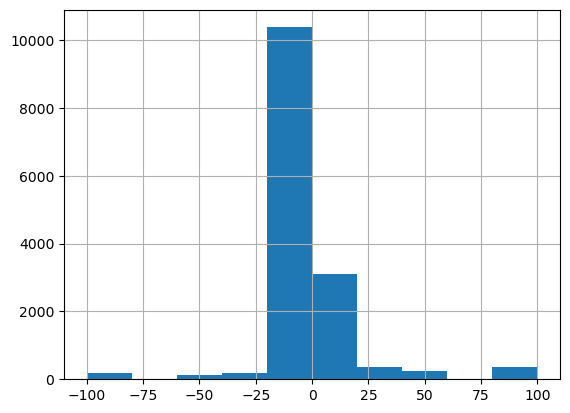

In [176]:
immediate_reward.immediate_reward.hist()
immediate_reward.immediate_reward.value_counts()

In [177]:
immediate_reward['state_action_id'] = immediate_reward.agg('{0[state]:.0f}-{0[action]:.0f}'.format, axis=1)

In [181]:
pr_trans[(pr_trans.state==0) & (pr_trans.action == 71)]

,sans_id,pr_t,state,action,nstate


In [182]:
pr_sans[pr_sans.sa_id=='0-71']['pr_sa']

Series([], Name: pr_sa, dtype: float64)

In [183]:
0.000332 * train_set.shape[0]

27.488936

In [184]:
pr_nstate_state_action.sans_id

0          53-169-53
1          44-169-44
2        577-169-577
3        409-169-409
4        473-169-473
            ...     
41415    639-192-468
41416    639-171-639
41417    536-218-651
41418     571-169-22
41419    255-191-171
Name: sans_id, Length: 41420, dtype: object

In [185]:
pr_nstate_state_action

,sans_id,pr_sans,sa_id
0,53-169-53,0.001002,53-169
1,44-169-44,0.000978,44-169
2,577-169-577,0.000930,577-169
3,409-169-409,0.000930,409-169
4,473-169-473,0.000858,473-169
...,...,...,...
41415,639-192-468,0.000012,639-192
41416,639-171-639,0.000012,639-171
41417,536-218-651,0.000012,536-218
41418,571-169-22,0.000012,571-169


In [186]:
pr_nstate_state_action

,sans_id,pr_sans,sa_id
0,53-169-53,0.001002,53-169
1,44-169-44,0.000978,44-169
2,577-169-577,0.000930,577-169
3,409-169-409,0.000930,409-169
4,473-169-473,0.000858,473-169
...,...,...,...
41415,639-192-468,0.000012,639-192
41416,639-171-639,0.000012,639-171
41417,536-218-651,0.000012,536-218
41418,571-169-22,0.000012,571-169


In [187]:
(train_set.icustay_id == 299994).any()

False

In [188]:
test_set.to_csv('data/test_{}_traj_{}.csv'.format(shaping_name, seed))
train_set.to_csv('data/train_{}_traj_{}.csv'.format(shaping_name, seed))

# Training a policy

In [189]:
immediate_reward[['state', 'action', 'immediate_reward']]
# matrix of immediate rewards
sar = np.full((n_states, 7**3), np.nan)
for state, action, reward in immediate_reward[['state', 'action', 'immediate_reward']].to_numpy():
    sar[int(state), int(action)] = reward

# Qn = {} # maps n to q tables

In [190]:
np.nanmax(sar[0, :])

0.020000000000000018

In [191]:
# According to the tabular FQI algorithm in Ernst, Geurts & Wehenkel (2005), Figure 1
# and Peine's supplementary discussion "A: Evaluation of Policies".
def peine_mc_iterate(snsasr, r, Qn, gamma, n_epochs=1, learning_rate=0.1):
    """
    Monte-carlo-based iteration of the training procedure according to tabular FQI & Peine's supplementary discussion.
    
    snsas: numpy ndarray with discretized state-nextstate-action tuples
    r: a function that returns the immediate reward for a state-action pair
    Qn: dictionary that maps iteration indices to Qn-estimates
    n: iteration number
    gamma: discount factor
    n_epochs: number of times to iterate over dataset
    learning rate: learning rate alpha
    """
    def epoch(snsasr, r, Qn, gamma, learning_rate):
        for i, (s, ns, a, er) in enumerate(snsasr):
            Qn[s,a] = Qn[s,a] + learning_rate * (er + gamma * np.max(Qn[int(ns),:]) - Qn[s,a])
        return Qn
    assert Qn.shape == (n_states+2, 7**3)
    for n in range(n_epochs):
        Qn = epoch(snsasr, r, Qn, gamma, learning_rate)
        print('.', end='')
    return Qn


def ernst_iterate(snsasr, Qn, n, gamma, regressor, action_space, state_repr=None, action_repr=to_discrete_action_bins):
    """
    snsas: numpy ndarray with discretized state_id-nextstate_id-action_id tuples
    r: immediate rewards
    Qn: dictionary that maps iteration indices to Qn estimates/estimators
    n: iteration number
    gamma: discount factor
    regression: sklearn regression class
    action_space: iterator that retuns all actions in
    action_repr: function that returns the action representation
    """
    def batches(X, batch_size):
        n_batches = int(math.ceil(X.shape[0] / batch_size))
        batches = []
        for i in range(n_batches):
            batch_start = i * batch_size
            batch_end = min(batch_start + batch_size, X.shape[0])
            batches.append((batch_start, batch_end))
        return batches

    def prediction_set(X, action_space):
        shape_x = X.shape
        n_actions = action_space.shape[0]
        action_dims = action_space.shape[1]
        repeated_X = X.repeat(n_actions, axis=0).reshape((shape_x[0] * n_actions, shape_x[1]))
        repeated_action_reprs = np.tile(action_space, (shape_x[0], 1)).reshape(repeated_X.shape[0], action_dims)
        return np.concatenate([repeated_X, repeated_action_reprs], axis=1)

    Q_hat = Qn[n]
    n = n + 1
    # terminal states only
    snsasr_t = snsasr[snsasr[:,1] >= 650] # 650 = number of non-terminal states
    r_t = snsasr_t[:, 3]
    # non-terminal states only
    snsasr = snsasr[snsasr[:,1] < 650] # 650 = number of non-terminal states
    a_reprs = np.array(list(map(action_repr, snsasr[:,2])))
    action_space_reprs = np.array(list(map(action_repr, action_space)))
    s_reprs = state_repr.transform(snsasr[:, 0].reshape(-1, 1))
    ns_reprs = state_repr.transform(snsasr[:, 1].reshape(-1, 1))
    r = snsasr[:, 3]
    X_train = hstack((s_reprs, a_reprs))
    # generate prediction dataset of length X.shape[0] * len(action_space)
    batch_size = int(X_train.shape[0] / 100)
    y_train = np.array([])
    for batch_start, batch_end in batches(X_train, batch_size):
        X_batch = ns_reprs[batch_start:batch_end, :].toarray()
        X_preds = prediction_set(X_batch, action_space_reprs)
        # predict Q scores for prediction dataset
        y_preds = Q_hat.predict(X_preds)
        # create targets with immediate reward and highest Q score for each row
        y_preds = y_preds.reshape(X_batch.shape[0], len(action_space_reprs))
        y_train = np.concatenate([y_train, r[batch_start:batch_end] + gamma * y_preds.max(axis=1)], axis=0)
        print('.', end ='')
    # terminal states
    a_reprs_t = np.array(list(map(action_repr, snsasr_t[:,2])))
    s_reprs_t = state_repr.transform(snsasr_t[:, 0].reshape(-1, 1))
    X_train_t = hstack((s_reprs_t, a_reprs_t))
    y_train_t = r_t
    print("y_train_t {}".format(y_train_t.shape))
    X_train_n = vstack((X_train_t, X_train))
    print("y_train {}".format(y_train.shape))
    y_train = np.concatenate((y_train, y_train_t))
    print("y_train {}".format(y_train.shape))
    print("X_train_n {}".format(X_train_n.shape))
    Q_hat_new = regressor()
    Q_hat_new.fit(X_train_n, y_train)
    return n, Q_hat_new


# TODO
# implement a regressor that wraps an OLS regressor in the following way:
#  1. creates an OLS regressor for each state
#  2. implements a predict() function that first looks up the right state OLS
#     and then calls predict() on the regressor there with the action levels as input
#  3. implements a fit() function that first segments X into buckets with the same state-action pair
#     then creates a regressor for that pair
#     and calls fit() on that pair << TODO: BUT GIVEN WHAT INPUT? does this only work for a three-dimensional action input?
class PerStateActionOLS():
    def __init__(self, states, default=None):
        self.regressors = {
            state: LinearRegression() for state in states
        }
        self.default = default
        
    def fit(self, X, y, states):
        """
        Fits a set of 
        """
        assert len(X) == len(states) == len(y), "Number of train samples, labels and states should be equal"
        X = np.array(X)
        X_df = pd.DataFrame(X, columns=['X_{}'.format(i) for i in range(X.shape[1])])
        X_cols = list(X_df.columns)
        X_df.loc[:, 'state'] = states
        X_df.loc[:, 'y'] = y
        groups = X_df.groupby('state')
        for k in groups.groups.keys():
            X_group = groups.get_group(k)[X_cols].to_numpy()
            y_group = groups.get_group(k)['y'].to_numpy()
            self.regressors[k].fit(X_group, y_group)
    
    def predict(self, X, states):
        def predict_single(row, X_cols):
            if row.state in self.regressors.keys():
                return self.regressors[row.state].predict(row[X_cols].to_numpy().reshape(1,-1))
            else:
                if self.default is None:
                    raise ValueError('Cannot predict for state {} without default prediction.'.format(row.state))
                else:
                    return self.default
            
        if isinstance(X, Iterable):
            assert len(X) == len(states), "Number of train samples, labels and states should be equal"
        X = np.array(X)
        X_df = pd.DataFrame(X, columns=['X_{}'.format(i) for i in range(X.shape[1])])
        X_cols = list(X_df.columns)
        X_df.loc[:, 'state'] = states
        predictions = X_df.apply(lambda x: predict_single(x, X_cols), axis=1)
        return predictions

class OneHotStateActionOLS():
    def __init__(self, obs_states, all_states=range(650), *args, **kwargs):
        # TODO: ensure that all states are passed
        if type(obs_states) == set:
            obs_states = list(obs_states)
        obs_states = np.array(obs_states).reshape(-1, 1)
        self.state_encoder = OneHotEncoder(categories=[all_states,]).fit(obs_states)
        self.regressor = LinearRegression()
    
    def encode(self, X, states):
        state_encoding = self.state_encoder.transform(states)
        return np.concatenate((X, state_encoding.todense()), axis=1)

    def fit(self, X, y):
        self.regressor.fit(X, y)
    
    def predict(self, X):
        X = np.array(X)
        states = np.array(states).reshape(-1, 1)
        X_new = self.encode(X, states)
        return self.regressor.predict(X_new)


class DummyRegressor:
    def __init__(self, return_val=0):
        self.return_val = return_val
        
    def predict(self, X, *args, **kwargs):
        return np.repeat([self.return_val], X.shape[0]).reshape(-1, 1)

In [221]:
q_init_val = 0
q_init = np.full((n_states + 2, 7**3), float(q_init_val))
#  peine_mc_iterate(snsas, r, Qn, gamma, n_epochs=1, learning_rate=0.1):
q_mcp = peine_mc_iterate(
    # TODO: why are the NaNs here? how to deal with these?
    snsasr=train_set[['state', 'next_state', 'action_discrete', 'reward']].astype(int).to_numpy(),
    r=sar,
    Qn=q_init,
    gamma=GAMMA,
    n_epochs=10000,
    learning_rate=0.01,
)


.....

KeyboardInterrupt: 

In [ ]:
q_mcp_nan = q_mcp.copy()[:n_states, :]
q_mcp_nan[q_mcp_nan == 0.0] = np.nan
sns.histplot(q_mcp.ravel(), bins=200)
plt.xlabel('Q value')
plt.title('Histogram of all Q values in Q table')
plt.show()
sns.histplot(q_mcp_nan.ravel(), bins=200)
plt.xlabel('Q value')
plt.title('Histogram of nonzero Q values in Q table')
plt.show()
sns.histplot(q_mcp_nan.ravel(), log_scale=(False, True), bins=200)
plt.xlabel('Q value')
plt.title('Histogram of nonzero Q values in Q table, logscale')
plt.show()

In [ ]:
joblib.dump(
    {'hyperparameters': {
        'Q_init': q_init,
        'gamma': GAMMA,
        'n_epochs': 10000,
        'learning_rate': 0.01,
        'shaping': SHAPING,
        'shaping_scalar': COMPLIANCE_SCALAR,
    },
    'model': q_mcp_nan,
    },
    'models/peine_mc_{}_q_table_{}.bin'.format(shaping_name, seed),
    compress=True
)

In [ ]:
# derive policy by taking argmax over non-nan q values
# policy_mcp = np.full()
q_mcp_nan[np.isnan(q_mcp_nan).all(axis=1),:] = 0

best_action_indices = np.nanargmax(q_mcp_nan, axis=1)

action_index_grid = np.tile(np.array(range(7**3)), 650).reshape((650, 7**3))
best_action_grid = np.repeat(best_action_indices, 7**3).reshape((650, 7**3))
best_action_bool = best_action_grid == action_index_grid
assert best_action_bool.shape == (n_states, 7**3)
assert (best_action_bool.sum(axis=1) == 1).all()
mcp_greedy = best_action_bool.astype(float)
assert (mcp_greedy.sum(axis=1) == 1).all()

In [ ]:
# derive policy by taking softmax
q_mcp_neg = q_mcp.copy()[:n_states, :]
q_mcp_neg[q_mcp_neg == 0.0] = float('-inf')
mcp_softmax = scipy.special.softmax(q_mcp_neg, axis=1)
assert mcp_softmax.shape == (n_states, 7**3)
assert (mcp_greedy.sum(axis=1) == 1).all()

In [ ]:
best_s, best_a = np.unravel_index(np.nanargmax(q_mcp_nan), (n_states, 7**3))
print("Global highest Q value {} for tv, fio2, peep ranges: {}".format(q_mcp_nan[best_s, best_a], to_action_ranges(best_a)))
best_mean_a, best_mean_a_q = np.nanargmax(np.nanmean(q_mcp_nan, axis=0)), np.nanmax(np.nanmean(q_mcp_nan, axis=0))
print("Highest avg Q value across states {} for tv, fio2, peep ranges: {}".format(best_mean_a_q, to_action_ranges(best_mean_a)))
best_med_a, best_med_a_q = np.nanargmax(np.nanmedian(q_mcp_nan, axis=0)), np.nanmax(np.nanmedian(q_mcp_nan, axis=0))
print("Highest median Q value across states {} for tv, fio2, peep ranges: {}".format(best_med_a, to_action_ranges(best_med_a)))
sns.histplot(q_mcp_nan[mcp_greedy == 1.0].ravel(), log_scale=(False, True), bins=200)
plt.xlabel('Q value')
plt.title('Histogram of Q values greedy policy')
plt.show()

In [ ]:
train_set['positive_outcome'] = train_set['mort90day'] == 'f'
estimated_mort_state_visit = train_set.groupby('state').mean('positive_outcome')[['positive_outcome']].to_numpy()

In [ ]:
sns.scatterplot(x=np.nanmean(q_mcp_nan, axis=1), y=estimated_mort_state_visit.reshape(n_states,))
plt.xlabel('Mean estimated Q value')
plt.ylabel('Average outcome')
plt.title('Outcome vs mean Q value estimates')
plt.show()
sns.scatterplot(x=np.nanmax(q_mcp_nan, axis=1), y=estimated_mort_state_visit.reshape(n_states,))
plt.xlabel('Max estimated Q value')
plt.ylabel('Average outcome')
plt.title('Outcome vs max Q value estimates')
plt.show()
sns.scatterplot(x=np.nanmedian(q_mcp_nan, axis=1), y=estimated_mort_state_visit.reshape(n_states,))
plt.xlabel('Max estimated Q value')
plt.ylabel('Average outcome')
plt.title('Outcome vs median Q value estimates')
plt.show()

In [ ]:
q_vars = np.nanvar(q_mcp_nan, axis=1)
q_means = np.nanmean(q_mcp_nan, axis=1)
q_medians = np.nanmedian(q_mcp_nan, axis=1)
q_maxs = np.nanmax(q_mcp_nan, axis=1)
q_mins = np.nanmin(q_mcp_nan, axis=1)
stacked = np.column_stack((q_means, q_medians, q_maxs, q_mins, q_vars))
xs = range(n_states)
means_sorted = np.array(sorted(stacked, key=lambda x: x[0]))
means_upper = means_sorted[:, 0] + means_sorted[:, -1]
means_lower = means_sorted[:, 0] - means_sorted[:, -1]
axs = sns.lineplot(x=xs, y=means_sorted[:, 0])
axs.fill_between(x=xs, y1=means_lower, y2=means_upper, alpha=.3)
axs.set_ylim(-150, 150)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Mean Q values per state +- 1 var')
plt.show()

medians_sorted = np.array(sorted(stacked, key=lambda x: x[1]))
means_upper = medians_sorted[:, 0] + medians_sorted[:, -1]
means_lower = medians_sorted[:, 0] - medians_sorted[:, -1]
axs = sns.lineplot(x=xs, y=medians_sorted[:, 1])
axs.fill_between(x=xs, y1=means_lower, y2=means_upper, alpha=.3)
axs.set_ylim(-150, 150)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Median Q values per state +- 1 var')
plt.show()

maxs_sorted = np.array(sorted(stacked, key=lambda x: x[2]))
axs = sns.lineplot(x=xs, y=maxs_sorted[:, 2])
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Max Q values per state')
plt.show()

mins_sorted = np.array(sorted(stacked, key=lambda x: x[3]))
axs = sns.lineplot(x=xs, y=mins_sorted[:, 3])
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Min Q values per state')
plt.show()

In [ ]:
def sortnan(x, index):
    return float('-inf') if np.isnan(x[index]) else x[index]

q_vars = np.nanvar(q_mcp_nan, axis=0)
q_means = np.nanmean(q_mcp_nan, axis=0)
q_medians = np.nanmedian(q_mcp_nan, axis=0)
q_maxs = np.nanmax(q_mcp_nan, axis=0)
q_mins = np.nanmin(q_mcp_nan, axis=0)
stacked = np.column_stack((q_means, q_medians, q_maxs, q_mins, q_vars))
xs = range(7**3)
means_sorted = np.array(sorted(stacked, key=lambda x: sortnan(x, 0)))
means_upper = means_sorted[:, 0] + means_sorted[:, -1]
means_lower = means_sorted[:, 0] - means_sorted[:, -1]
axs = sns.lineplot(x=xs, y=means_sorted[:, 0])
axs.fill_between(x=xs, y1=means_lower, y2=means_upper, alpha=.3)
axs.set_ylim(-150, 150)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Mean Q values per action +- 1 var')
plt.show()

medians_sorted = np.array(sorted(stacked, key=lambda x: sortnan(x, 1)))
means_upper = medians_sorted[:, 0] + medians_sorted[:, -1]
means_lower = medians_sorted[:, 0] - medians_sorted[:, -1]
axs = sns.lineplot(x=xs, y=medians_sorted[:, 1])
axs.fill_between(x=xs, y1=means_lower, y2=means_upper, alpha=.3)
axs.set_ylim(-150, 150)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Median Q values per action +- 1 var')
plt.show()

maxs_sorted = np.array(sorted(stacked, key=lambda x: sortnan(x, 2)))
axs = sns.lineplot(x=xs, y=maxs_sorted[:, 2])
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Max Q values per action')
plt.show()

mins_sorted = np.array(sorted(stacked, key=lambda x: sortnan(x, 3)))
axs = sns.lineplot(x=xs, y=mins_sorted[:, 3])
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Min Q values per action')
plt.show()

In [ ]:
behavior_policy_df = (test_set.value_counts(['state', 'action_discrete']) / test_set.value_counts(['state']))
assert (1.0 - behavior_policy_df.groupby('state').sum() < 1e10).all(), "Policy action probs should sum to 1 per state"
behavior_policy_df = behavior_policy_df.reset_index()

In [ ]:
behavior_policy_df

In [ ]:
behavior_policy_df = train_set.value_counts(['state', 'action_discrete']) / train_set.value_counts(['state'])
assert (1.0 - behavior_policy_df.groupby('state').sum() < 1e10).all(), "Policy action probs should sum to 1 per state"

behavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state')[0]
behavior_policy_states = set(behavior_policy_pivot.index.unique())
for s in range(n_states):
    if s not in behavior_policy_states:
        action_probs = [1.0 / (7**3),] * 7**3 # uniform distribution
        for i, p in enumerate(action_probs):
            behavior_policy_pivot.loc[s] = [s, i, p]

behavior_policy_pivot = behavior_policy_pivot.sort_values(['state'])

for a in range(7**3):
    if a not in behavior_policy_pivot.columns:
        behavior_policy_pivot.loc[:, a] = np.nan

behavior_policy_nan = behavior_policy_pivot[range(7**3)].to_numpy()
assert (1- (np.nansum(behavior_policy_nan, axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
behavior_policy = np.nan_to_num(behavior_policy_nan, 0.0)
assert (1- (behavior_policy.sum(axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
assert behavior_policy.shape == (n_states, 7**3), "Behavior policy should cover all states and actions"
mcp_greedy_mask = mcp_greedy.astype(bool)
assert (mcp_greedy_mask.sum(axis=1) == 1).all(), "Greedy policy mask should mask out all-but-one action"
joblib.dump(behavior_policy, "models/clinicians_policy_train_{}.bin".format(seed), compress=True)


In [ ]:
behavior_policy_df = test_set.value_counts(['state', 'action_discrete']) / test_set.value_counts(['state'])
assert (1.0 - behavior_policy_df.groupby('state').sum() < 1e10).all(), "Policy action probs should sum to 1 per state"

behavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state')[0]

for a in range(7**3):
    if a not in behavior_policy_pivot.columns:
        behavior_policy_pivot.loc[:, a] = np.nan
behavior_policy_states = set(behavior_policy_pivot.index.unique())
for s in range(n_states):
    if s not in behavior_policy_states:
        action_probs = [1.0 / (7**3),] * 7**3 # uniform distribution
        for i, p in enumerate(action_probs):
            behavior_policy_pivot.loc[s] = [1/(7**3),]*(7**3)

behavior_policy_pivot = behavior_policy_pivot.sort_values(['state'])

behavior_policy_nan = behavior_policy_pivot[range(7**3)].to_numpy()
assert (1- (np.nansum(behavior_policy_nan, axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
behavior_policy = np.nan_to_num(behavior_policy_nan, 0.0)
assert (1- (behavior_policy.sum(axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
assert behavior_policy.shape == (n_states, 7**3), "Behavior policy should cover all states and actions"
mcp_greedy_mask = mcp_greedy.astype(bool)
assert (mcp_greedy_mask.sum(axis=1) == 1).all(), "Greedy policy mask should mask out all-but-one action"
joblib.dump(behavior_policy, "models/clinicians_policy_test_{}.bin".format(seed), compress=True)

In [ ]:
behavior_policy

In [ ]:
train_test = pd.concat([train_set, test_set])
behavior_policy_df = train_test.value_counts(['state', 'action_discrete']) / train_test.value_counts(['state'])
assert (1.0 - behavior_policy_df.groupby('state').sum() < 1e10).all(), "Policy action probs should sum to 1 per state"

behavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state')[0]
for a in range(7**3):
    if a not in behavior_policy_pivot.columns:
        behavior_policy_pivot.loc[:, a] = np.nan

behavior_policy_nan = behavior_policy_pivot[range(7**3)].to_numpy()
assert (1- (np.nansum(behavior_policy_nan, axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
behavior_policy = np.nan_to_num(behavior_policy_nan, 0.0)
assert (1- (behavior_policy.sum(axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
assert behavior_policy.shape == (n_states, 7**3), "Behavior policy should cover all states and actions"
mcp_greedy_mask = mcp_greedy.astype(bool)
assert (mcp_greedy_mask.sum(axis=1) == 1).all(), "Greedy policy mask should mask out all-but-one action"
joblib.dump(behavior_policy, "models/clinicians_policy_train_test_{}.bin".format(seed), compress=True)


In [ ]:
import scipy
scipy.stats.entropy(behavior_policy.ravel())

In [ ]:
sns.histplot(scipy.stats.entropy(behavior_policy, axis=1))
plt.title('Behavior policy per-state entropy')
plt.xlabel('Entropy') 
plt.show()

In [ ]:
sns.histplot(scipy.stats.entropy(mcp_softmax, axis=1))
plt.title('Softmax policy per-state entropy')
plt.xlabel('Entropy')
plt.show()

In [ ]:
print("Behavior policy argmax and greedy policy agreement: {}".format((behavior_policy.argmax(axis=1) == mcp_greedy.argmax(axis=1)).sum() / n_states))
sns.histplot(behavior_policy[mcp_greedy_mask], log_scale=(False, True))
plt.xlabel('Action probability greedy policy in behavior policy')
behavior_policy[mcp_greedy_mask].min(), behavior_policy[mcp_greedy_mask].max()

In [ ]:
evaluation_policy = mcp_greedy

behavior_policy_ranks = np.flip(behavior_policy.argsort(axis=1), axis=1)
ep_bp_ranks = []
for s in range(n_states):
    ep_a = evaluation_policy[s,:].argmax()
    bp_rank = np.where(behavior_policy_ranks[s, :] == ep_a)[0][0]
    ep_bp_ranks.append(bp_rank)

sns.histplot(ep_bp_ranks, bins=60)
plt.title('Greedy policy action ranks in behavior policy')
plt.xlabel('Rank')
plt.show()

behavior_policy_ranked_probs = np.flip(np.sort(behavior_policy, axis=1), axis=1)
ep_bp_prob_mass = []
for s in range(n_states):
    ep_a = evaluation_policy[s,:].argmax()
    bp_rank = np.where(behavior_policy_ranks[s, :] == ep_a)[0][0]
    ep_bp_prob_mass.append(behavior_policy_ranked_probs[s, 0:bp_rank].sum())

sns.histplot(ep_bp_prob_mass)
plt.title('Probability mass up to greedy action')
plt.xlabel('Action probs')
plt.show()
np.array(ep_bp_prob_mass).min(), np.array(ep_bp_prob_mass).max()

In [ ]:
# state-values of 

In [ ]:
joblib.dump(mcp_greedy, "models/mcp_greedy_policy_{}_{}.bin".format(seed, shaping_name), compress=True)
joblib.dump(mcp_softmax, "models/mcp_softmax_policy_{}_{}.bin".format(seed, shaping_name), compress=True)
